<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#DSC" data-toc-modified-id="DSC-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>DSC</a></span></li><li><span><a href="#Validation-label" data-toc-modified-id="Validation-label-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Validation label</a></span></li><li><span><a href="#실험1" data-toc-modified-id="실험1-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>실험1</a></span></li><li><span><a href="#실험2" data-toc-modified-id="실험2-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>실험2</a></span></li><li><span><a href="#실험3" data-toc-modified-id="실험3-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>실험3</a></span></li><li><span><a href="#실험4" data-toc-modified-id="실험4-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>실험4</a></span></li><li><span><a href="#실험5" data-toc-modified-id="실험5-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>실험5</a></span></li><li><span><a href="#실험6" data-toc-modified-id="실험6-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>실험6</a></span></li></ul></div>

In [5]:
import json
import matplotlib.pyplot as plt
import os 
import pandas as pd
import nibabel as nib
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

C:\Users\wogur\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# DSC

In [21]:
def dsc_calc(y_true, y_pred):
    y_true = y_true.reshape(-1)
    y_pred = y_pred.reshape(-1)
    intersection = np.sum(y_true * y_pred)
    return (2 * intersection) / (np.sum(y_true) + np.sum(y_pred))

def dsc_by_label(y_true, y_pred, label_index):
    return dsc_calc(y_true[:,:,:,label_index], y_pred[:,:,:,label_index])

def label_encoding(label):
    label_encoder = LabelEncoder()
    shape = label.shape
    label = label.reshape(-1)
    label = label_encoder.fit_transform(label)
    label = to_categorical(label, 8)
    label = label.reshape(shape + (8,))
    
    return label

def evaluate(y_true1, y_true2, y_pred1, y_pred2):
    print('Valid 1')
    dsc = dsc_calc(y_true1, y_pred1)
    print('DSC: {0:.4f}'.format(dsc))

    dsc_mean1 = list()
    for i in range(8):
        dsc_i = dsc_by_label(y_true1, y_pred1, i)
        if i!=0:
            dsc_mean1.append(dsc_i)
        print('label_{0:}: {1:.3f}'.format(i, dsc_i))
    print('Average DSC: {0:.3f}'.format(np.mean(dsc_mean1)))

    print('='*50)

    print('Valid 2')
    dsc = dsc_calc(y_true2, y_pred2)
    print('DSC: {0:.4f}'.format(dsc))

    dsc_mean2 = list()
    for i in range(8):
        dsc_i = dsc_by_label(y_true2, y_pred2, i)
        if i!=0:
            dsc_mean2.append(dsc_i)
        print('label_{0:}: {1:.3f}'.format(i, dsc_i))
    print('Average DSC: {0:.3f}'.format(np.mean(dsc_mean2)))
    
    return dsc_mean1, dsc_mean2

In [22]:
def model_evaluate(folder,exp_name, metric, valid_images):
    exp = pd.read_csv('../{}/history/{}.csv'.format(folder,exp_name))
    exp_image_1 = nib.load('../{}/predict_image/{}/{}_0.nii'.format(folder,exp_name, exp_name)).get_data()
    exp_image_2 = nib.load('../{}/predict_image/{}/{}_1.nii'.format(folder,exp_name, exp_name)).get_data()
    print('exp_image_1 label: ',np.unique(exp_image_1))
    print('exp_image_2 label: ',np.unique(exp_image_2))
    print()
    exp_image_1 = label_encoding(exp_image_1)
    exp_image_2 = label_encoding(exp_image_2)
    print('encoding exp_image_1.shape: ',exp_image_1.shape)
    print('encoding exp_image_2.shape: ',exp_image_2.shape)
    print()

    fig, ax = plt.subplots(1,2, figsize=(12,5))
    ax[0].plot(exp['loss'], 'y', label='train loss')
    ax[0].plot(exp['val_loss'], 'r', label='val loss')
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('loss')
    ax[0].set_ylim([0,1])
    ax[0].legend(loc='upper right')

    ax[1].plot(exp['{}'.format(metric)], 'b', label='train {} coefficient'.format(metric))
    ax[1].plot(exp['val_{}'.format(metric)], 'g', label='val {} coefficient'.format(metric))
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('{}'.format(metric))
    ax[1].set_ylim([0,1])
    ax[1].legend(loc='lower right')

    fig, ax = plt.subplots(2,4, figsize=(20,10))
    for i in range(8):
        ax[i//4,i%4].plot(exp['DSC_{}'.format(i)], 'b', label='train DSC{}'.format(i))
        ax[i//4,i%4].plot(exp['val_DSC_{}'.format(i)], 'r', label='val DSC{}'.format(i))
        ax[i//4,i%4].set_xlabel('epoch')
        ax[i//4,i%4].set_ylabel('Dice Similarity Coefficient')
        ax[i//4,i%4].legend(loc='upper right')
        ax[i//4,i%4].set_ylim([0,1])

    val1_dsc, val2_dsc = evaluate(valid_images[0], valid_images[1], exp_image_1, exp_image_2)
    
    return val1_dsc, val2_dsc

# Validation label

In [11]:
valid_1 = nib.load('../dataset/ct_train_test/ct_train/ct_train_1019_label.nii/ct_train_1019_label.nii').get_data()
valid_2 = nib.load('../dataset/ct_train_test/ct_train/ct_train_1020_label.nii/ct_train_1020_label.nii').get_data()
print('valid_1.shape: ',valid_1.shape)
print('valid_2.shape: ',valid_2.shape)
print()
valid_1 = label_encoding(valid_1)
valid_2 = label_encoding(valid_2)
print('encoding valid_1.shape: ',valid_1.shape)
print('encoding valid_2.shape: ',valid_2.shape)

valid_1.shape:  (512, 512, 297)
valid_2.shape:  (512, 512, 363)

encoding valid_1.shape:  (512, 512, 297, 8)
encoding valid_2.shape:  (512, 512, 363, 8)


# 실험1

exp_image_1 label:  [  0 205 420 500 550 600 820 850]
exp_image_2 label:  [  0 205 420 500 550 600 820 850]

encoding exp_image_1.shape:  (512, 512, 297, 8)
encoding exp_image_2.shape:  (512, 512, 363, 8)

Valid 1
DSC: 0.9911
label_0: 0.996
label_1: 0.931
label_2: 0.900
label_3: 0.870
label_4: 0.925
label_5: 0.907
label_6: 0.708
label_7: 0.899
Average DSC: 0.877
Valid 2
DSC: 0.9853
label_0: 0.993
label_1: 0.904
label_2: 0.958
label_3: 0.954
label_4: 0.925
label_5: 0.938
label_6: 0.977
label_7: 0.946
Average DSC: 0.943


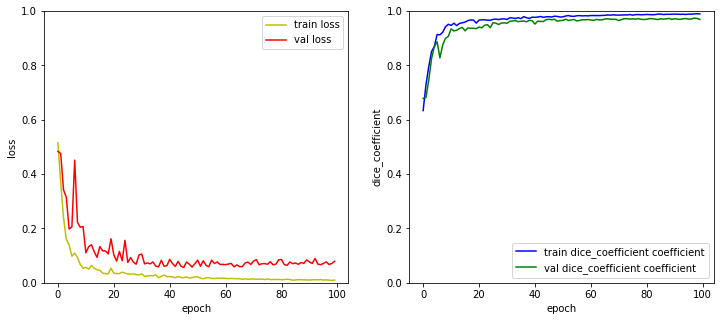

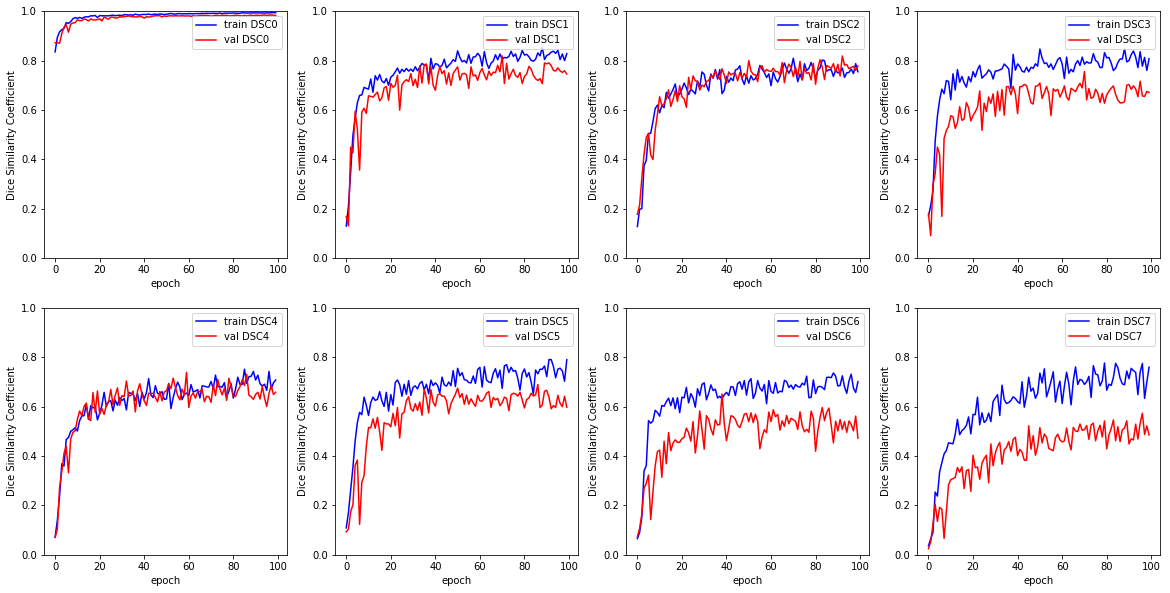

In [23]:
val1_dsc_exp1, val2_dsc_exp1 = model_evaluate('exp1234', 'UNET_3D', 'dice_coefficient', [valid_1, valid_2])

exp_image_1 label:  [  0 205 420 500 550 600 820 850]
exp_image_2 label:  [  0 205 420 500 550 600 820 850]

encoding exp_image_1.shape:  (512, 512, 297, 8)
encoding exp_image_2.shape:  (512, 512, 363, 8)

Valid 1
DSC: 0.9891
label_0: 0.996
label_1: 0.925
label_2: 0.917
label_3: 0.881
label_4: 0.893
label_5: 0.881
label_6: 0.488
label_7: 0.803
Average DSC: 0.827
Valid 2
DSC: 0.9805
label_0: 0.992
label_1: 0.891
label_2: 0.929
label_3: 0.925
label_4: 0.920
label_5: 0.927
label_6: 0.968
label_7: 0.892
Average DSC: 0.922


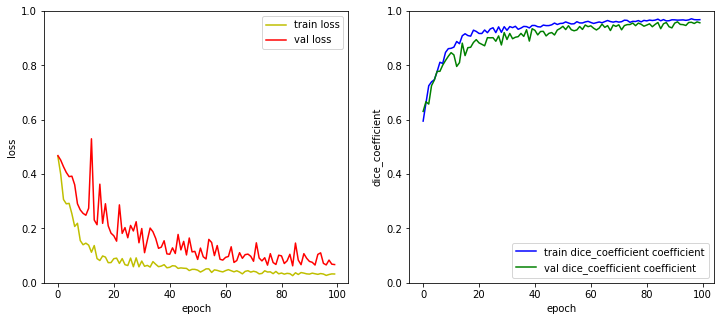

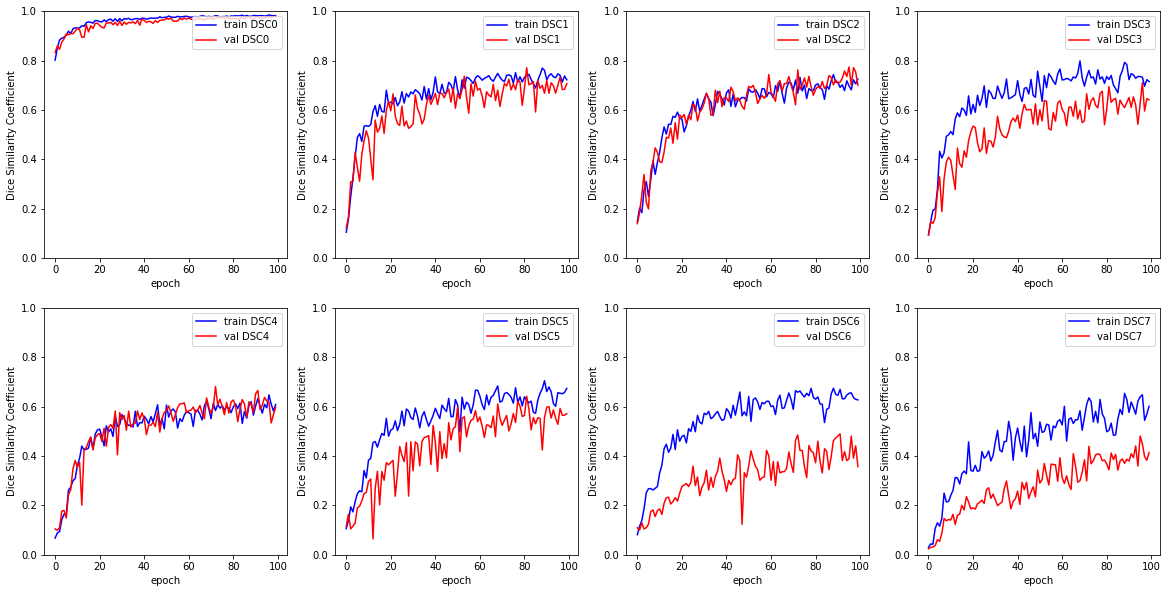

In [26]:
val1_dsc_exp2, val2_dsc_exp2 = model_evaluate('exp1234', 'UNET_3D_GN', 'dice_coefficient', [valid_1, valid_2])

exp_image_1 label:  [  0 205 420 500 550 600 820 850]
exp_image_2 label:  [  0 205 420 500 550 600 820 850]

encoding exp_image_1.shape:  (512, 512, 297, 8)
encoding exp_image_2.shape:  (512, 512, 363, 8)

Valid 1
DSC: 0.9921
label_0: 0.997
label_1: 0.930
label_2: 0.896
label_3: 0.865
label_4: 0.927
label_5: 0.913
label_6: 0.877
label_7: 0.856
Average DSC: 0.895
Valid 2
DSC: 0.9855
label_0: 0.993
label_1: 0.908
label_2: 0.955
label_3: 0.958
label_4: 0.938
label_5: 0.934
label_6: 0.978
label_7: 0.937
Average DSC: 0.944


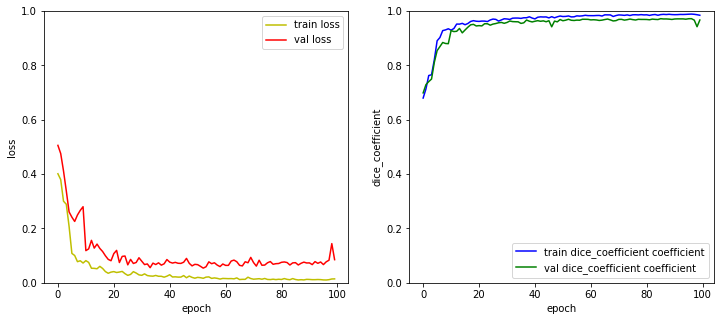

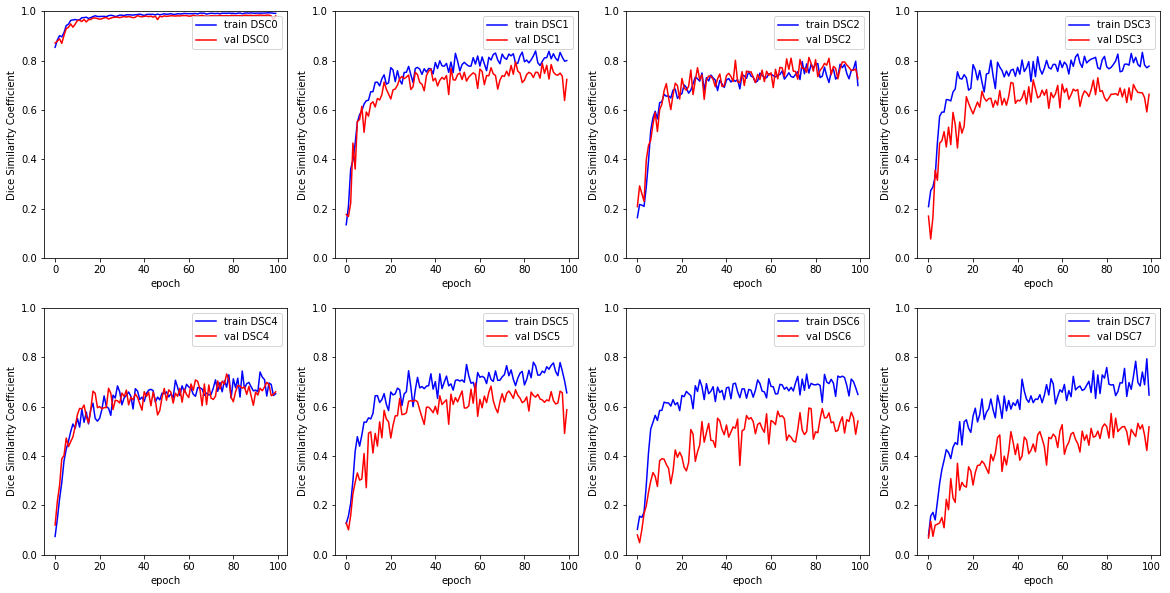

In [27]:
val1_dsc_exp3, val2_dsc_exp3 = model_evaluate('exp1234', 'UNET_3D_COORD', 'dice_coefficient', [valid_1, valid_2])

exp_image_1 label:  [  0 420 850]
exp_image_2 label:  [  0 205 420 500 550 600 820 850]

encoding exp_image_1.shape:  (512, 512, 297, 8)
encoding exp_image_2.shape:  (512, 512, 363, 8)

Valid 1
DSC: 0.9481
label_0: 0.974
label_1: 0.000
label_2: 0.000
label_3: 0.000
label_4: 0.000
label_5: 0.000
label_6: 0.000
label_7: 0.000
Average DSC: 0.000
Valid 2
DSC: 0.8461
label_0: 0.918
label_1: 0.000
label_2: 0.103
label_3: 0.000
label_4: 0.000
label_5: 0.000
label_6: 0.000
label_7: 0.023
Average DSC: 0.018


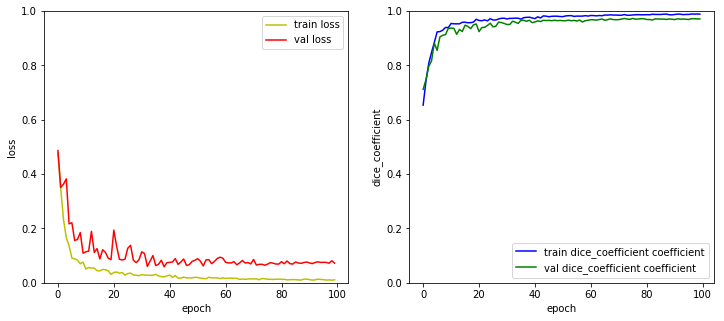

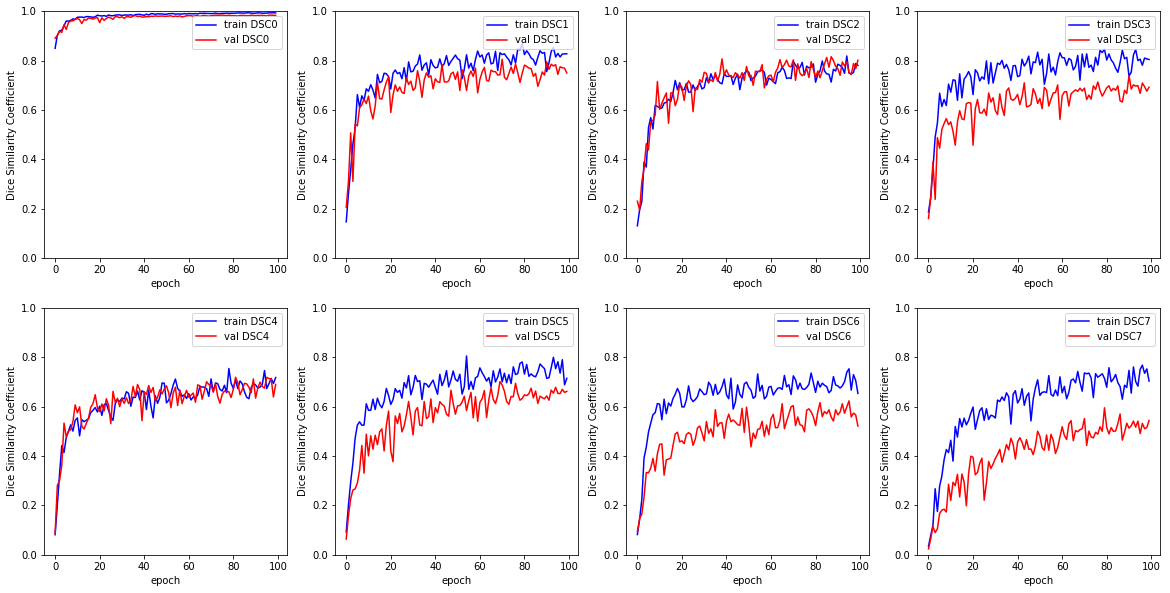

In [28]:
val1_dsc_exp4, val2_dsc_exp4 = model_evaluate('exp1234', 'UNET_3D_COORD_INPUT', 'dice_coefficient', [valid_1, valid_2])

exp_image_1 label:  [  0 205 420 500 550 600 820 850]
exp_image_2 label:  [  0 205 420 500 550 600 820 850]

encoding exp_image_1.shape:  (512, 512, 297, 8)
encoding exp_image_2.shape:  (512, 512, 363, 8)

Valid 1
DSC: 0.9897
label_0: 0.995
label_1: 0.910
label_2: 0.894
label_3: 0.834
label_4: 0.927
label_5: 0.923
label_6: 0.577
label_7: 0.877
Average DSC: 0.849
Valid 2
DSC: 0.9797
label_0: 0.991
label_1: 0.890
label_2: 0.961
label_3: 0.960
label_4: 0.922
label_5: 0.887
label_6: 0.889
label_7: 0.922
Average DSC: 0.919


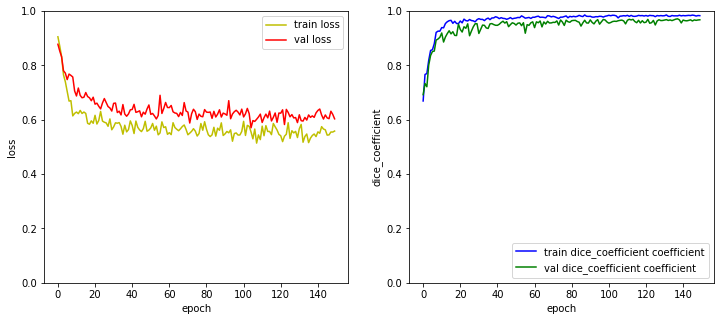

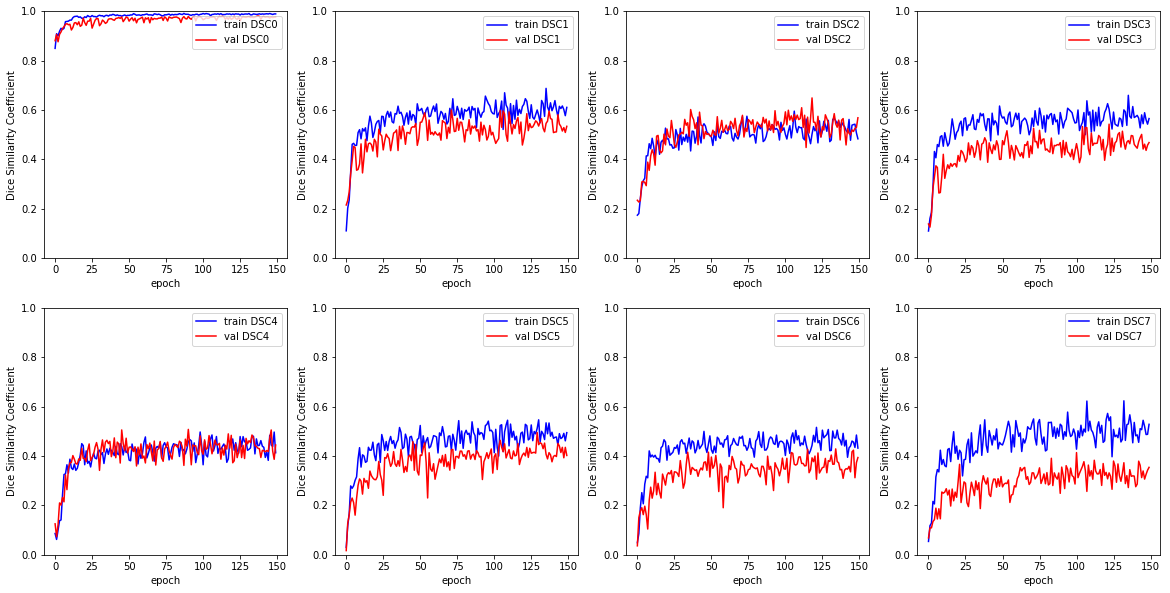

In [29]:
val1_dsc_exp5, val2_dsc_exp5 = model_evaluate('exp5678', 'UNET_3D', 'dice_coefficient', [valid_1, valid_2])

exp_image_1 label:  [  0 205 420 500 550 600 820 850]
exp_image_2 label:  [  0 205 420 500 550 600 820 850]

encoding exp_image_1.shape:  (512, 512, 297, 8)
encoding exp_image_2.shape:  (512, 512, 363, 8)

Valid 1
DSC: 0.9882
label_0: 0.996
label_1: 0.899
label_2: 0.915
label_3: 0.784
label_4: 0.876
label_5: 0.846
label_6: 0.335
label_7: 0.808
Average DSC: 0.780
Valid 2
DSC: 0.9803
label_0: 0.991
label_1: 0.889
label_2: 0.949
label_3: 0.950
label_4: 0.924
label_5: 0.882
label_6: 0.968
label_7: 0.880
Average DSC: 0.920


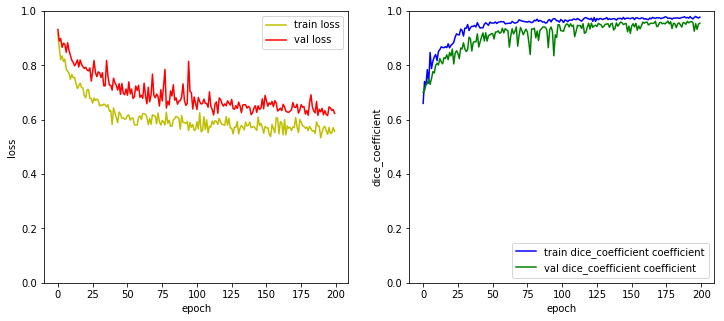

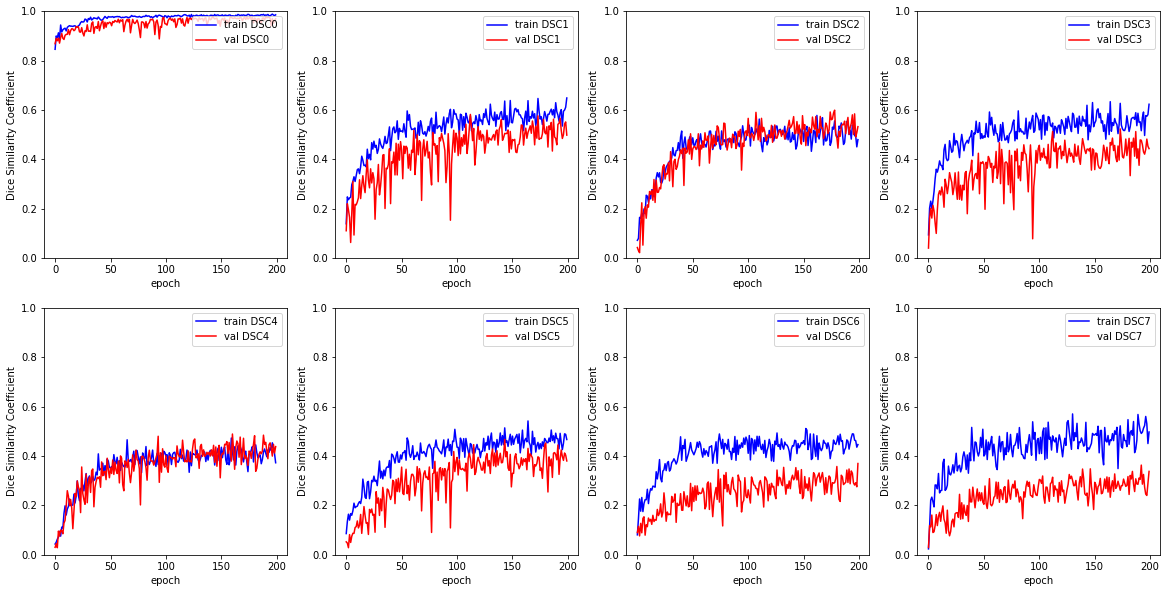

In [30]:
val1_dsc_exp6, val2_dsc_exp6 = model_evaluate('exp5678', 'UNET_3D_GN', 'dice_coefficient', [valid_1, valid_2])

exp_image_1 label:  [  0 205 420 500 550 600 820 850]
exp_image_2 label:  [  0 205 420 500 550 600 820 850]

encoding exp_image_1.shape:  (512, 512, 297, 8)
encoding exp_image_2.shape:  (512, 512, 363, 8)

Valid 1
DSC: 0.9882
label_0: 0.995
label_1: 0.898
label_2: 0.910
label_3: 0.878
label_4: 0.925
label_5: 0.839
label_6: 0.214
label_7: 0.864
Average DSC: 0.790
Valid 2
DSC: 0.9801
label_0: 0.991
label_1: 0.894
label_2: 0.955
label_3: 0.953
label_4: 0.921
label_5: 0.912
label_6: 0.924
label_7: 0.894
Average DSC: 0.922


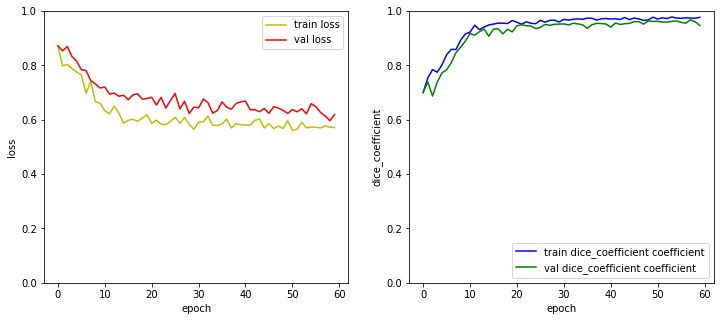

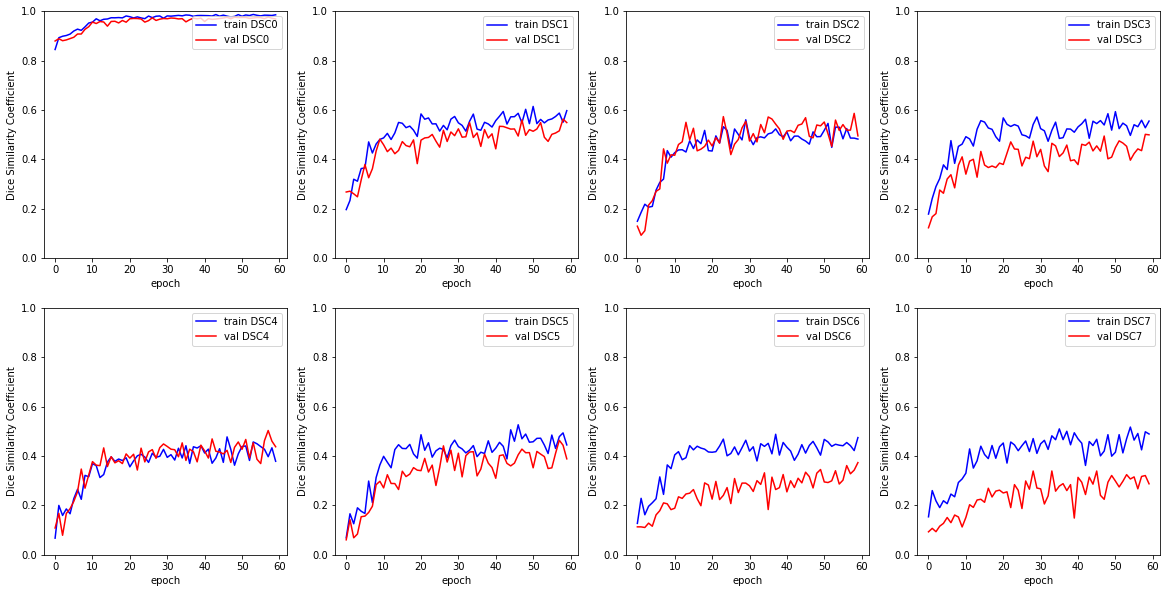

In [31]:
val1_dsc_exp7, val2_dsc_exp7 = model_evaluate('exp5678', 'UNET_3D_COORD', 'dice_coefficient', [valid_1, valid_2])

exp_image_1 label:  [  0 205 420 500 550 600 820 850]
exp_image_2 label:  [  0 205 420 500 550 600 820 850]

encoding exp_image_1.shape:  (512, 512, 297, 8)
encoding exp_image_2.shape:  (512, 512, 363, 8)

Valid 1
DSC: 0.9856
label_0: 0.994
label_1: 0.867
label_2: 0.885
label_3: 0.839
label_4: 0.767
label_5: 0.878
label_6: 0.679
label_7: 0.698
Average DSC: 0.802
Valid 2
DSC: 0.9740
label_0: 0.989
label_1: 0.841
label_2: 0.918
label_3: 0.920
label_4: 0.880
label_5: 0.889
label_6: 0.972
label_7: 0.812
Average DSC: 0.890


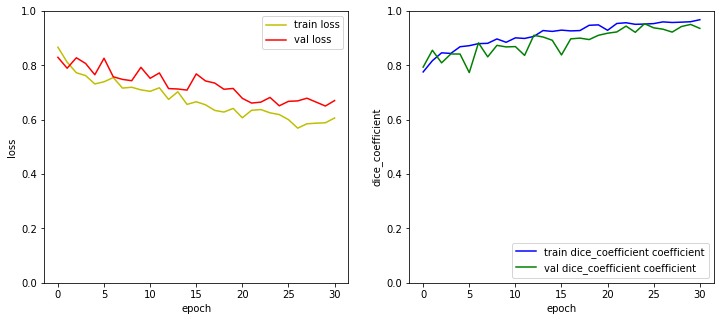

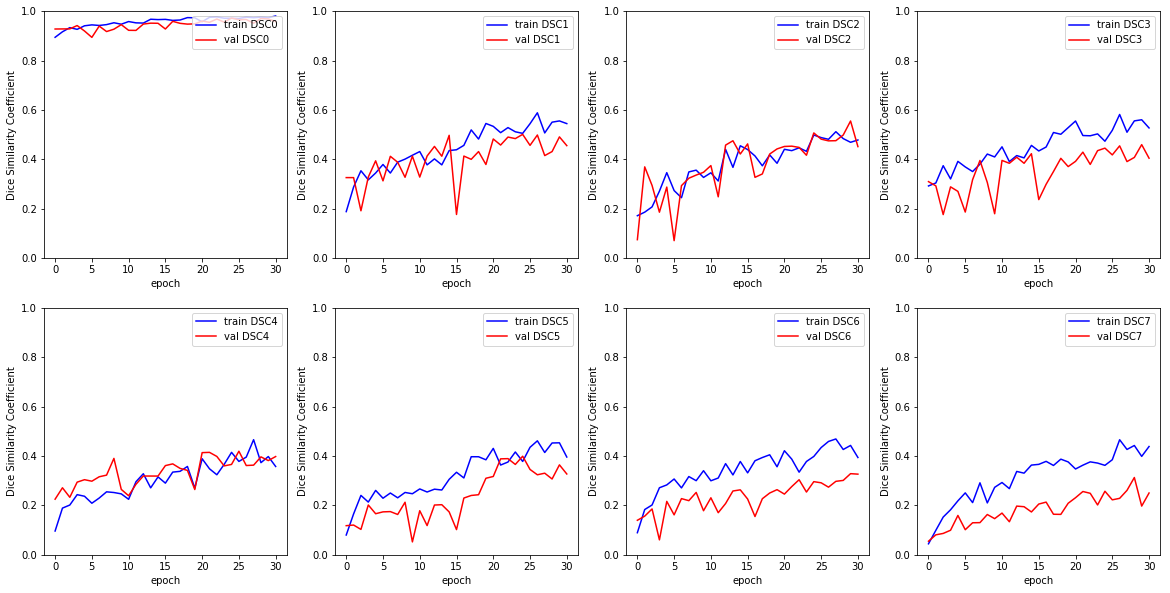

In [32]:
val1_dsc_exp8, val2_dsc_exp8 = model_evaluate('exp5678', 'UNET_3D_COORD_INPUT', 'dice_coefficient', [valid_1, valid_2])

exp_image_1 label:  [0]
exp_image_2 label:  [0]

encoding exp_image_1.shape:  (512, 512, 297, 8)
encoding exp_image_2.shape:  (512, 512, 363, 8)

Valid 1
DSC: 0.9481
label_0: 0.973
label_1: 0.000
label_2: 0.000
label_3: 0.000
label_4: 0.000
label_5: 0.000
label_6: 0.000
label_7: 0.000
Average DSC: 0.000
Valid 2
DSC: 0.8452
label_0: 0.916
label_1: 0.000
label_2: 0.000
label_3: 0.000
label_4: 0.000
label_5: 0.000
label_6: 0.000
label_7: 0.000
Average DSC: 0.000


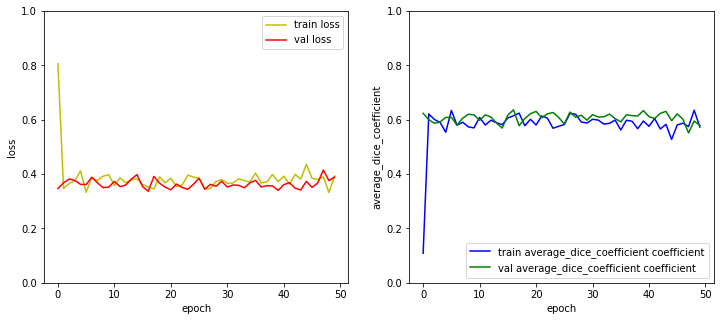

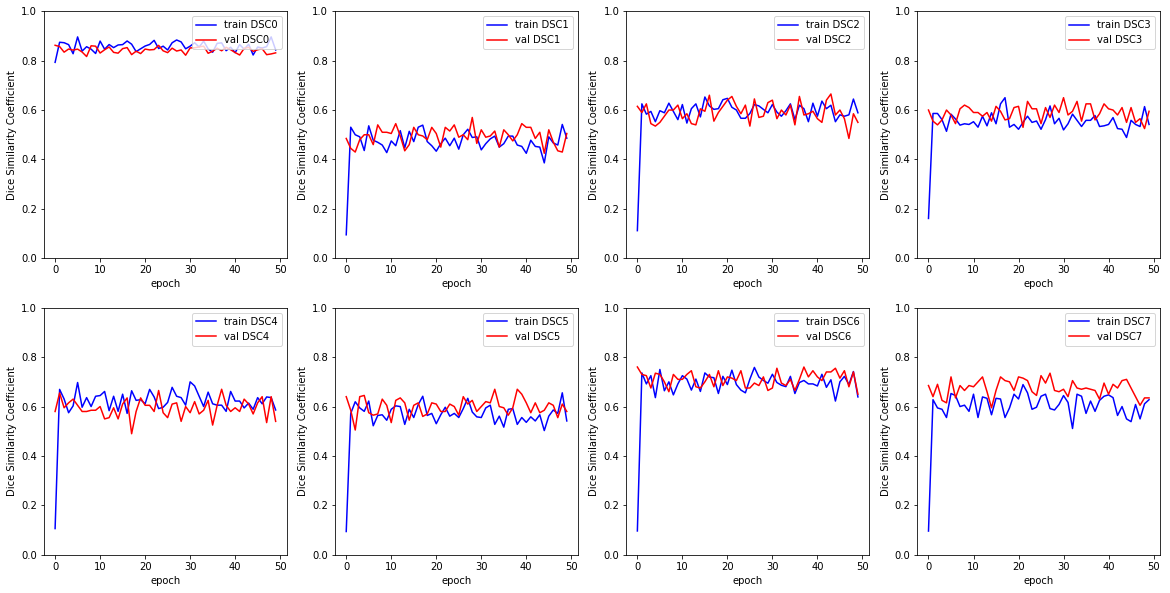

In [33]:
val1_dsc_exp9, val2_dsc_exp9 = model_evaluate('exp910111213141516', 'UNET_3D', 'average_dice_coefficient', [valid_1, valid_2])

exp_image_1 label:  [  0 205 420 500 550 600 820 850]
exp_image_2 label:  [  0 205 420 500 550 600 820 850]

encoding exp_image_1.shape:  (512, 512, 297, 8)
encoding exp_image_2.shape:  (512, 512, 363, 8)

Valid 1
DSC: 0.9882
label_0: 0.996
label_1: 0.899
label_2: 0.915
label_3: 0.784
label_4: 0.876
label_5: 0.846
label_6: 0.335
label_7: 0.808
Average DSC: 0.780
Valid 2
DSC: 0.9803
label_0: 0.991
label_1: 0.889
label_2: 0.949
label_3: 0.950
label_4: 0.924
label_5: 0.882
label_6: 0.968
label_7: 0.880
Average DSC: 0.920


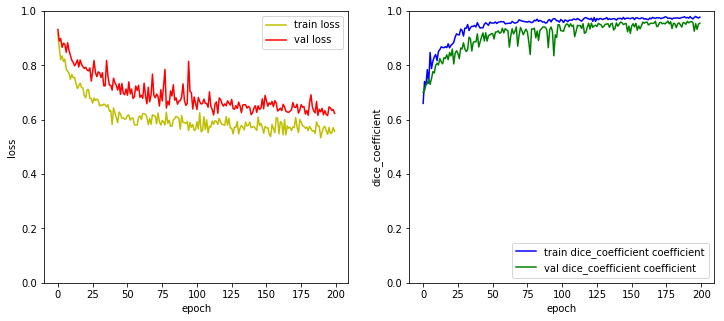

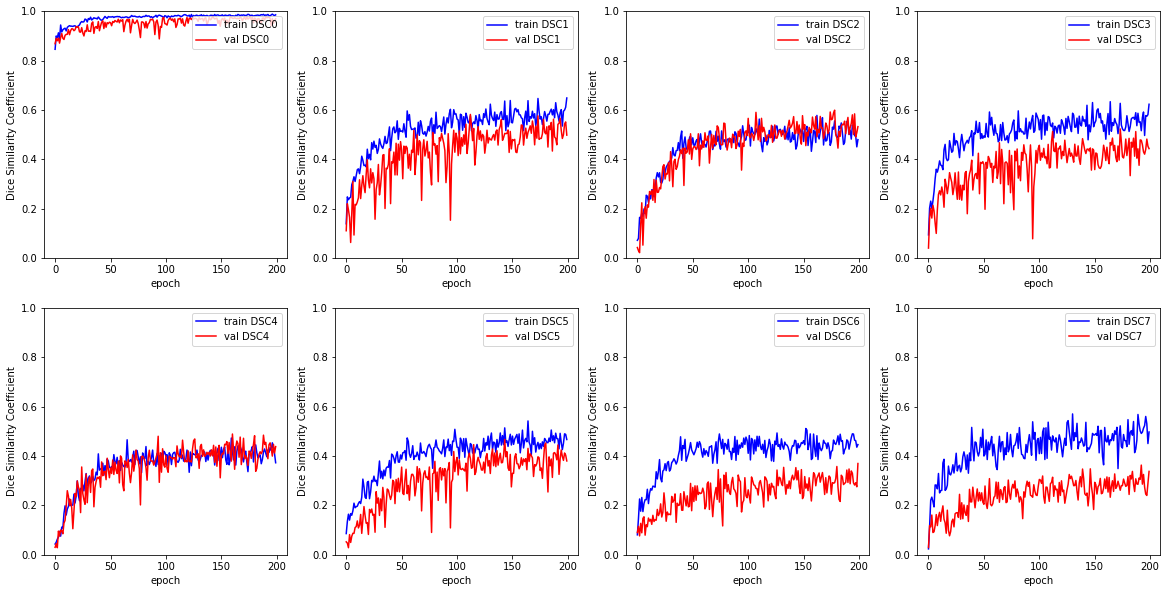

In [35]:
val1_dsc_exp10, val2_dsc_exp10 = model_evaluate('exp910111213141516', 'UNET_3D_GN', 'dice_coefficient', [valid_1, valid_2])

exp_image_1 label:  [  0 205 420 500 550 600 820 850]
exp_image_2 label:  [  0 205 420 500 550 600 820 850]

encoding exp_image_1.shape:  (512, 512, 297, 8)
encoding exp_image_2.shape:  (512, 512, 363, 8)

Valid 1
DSC: 0.9757
label_0: 0.991
label_1: 0.784
label_2: 0.824
label_3: 0.588
label_4: 0.835
label_5: 0.641
label_6: 0.202
label_7: 0.325
Average DSC: 0.600
Valid 2
DSC: 0.9192
label_0: 0.968
label_1: 0.796
label_2: 0.774
label_3: 0.755
label_4: 0.687
label_5: 0.424
label_6: 0.586
label_7: 0.435
Average DSC: 0.637


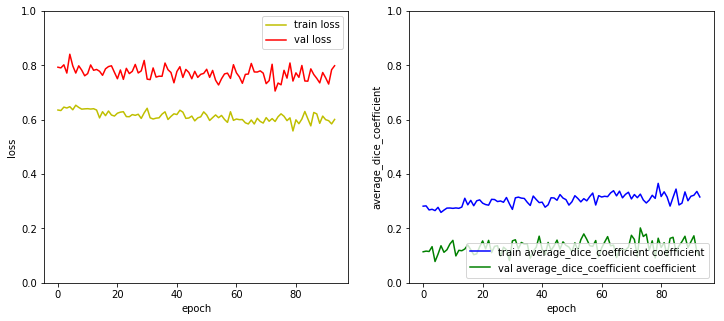

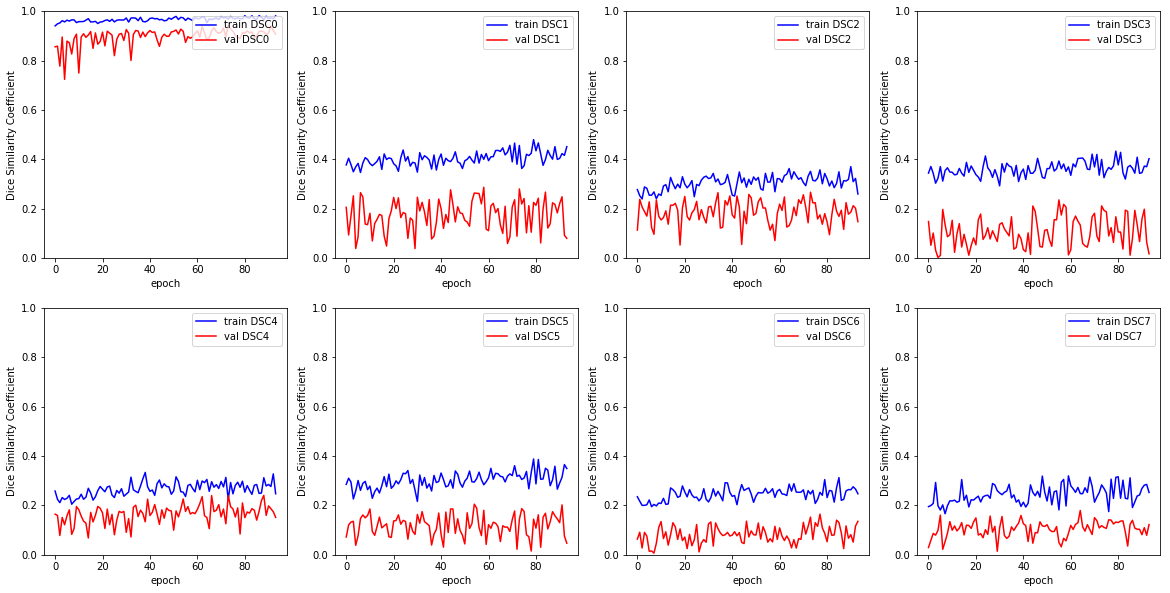

In [37]:
val1_dsc_exp11, val2_dsc_exp11 = model_evaluate('exp910111213141516', 'UNET_3D_BN', 'average_dice_coefficient', [valid_1, valid_2])

exp_image_1 label:  [0]
exp_image_2 label:  [0]

encoding exp_image_1.shape:  (512, 512, 297, 8)
encoding exp_image_2.shape:  (512, 512, 363, 8)

Valid 1
DSC: 0.9481
label_0: 0.973
label_1: 0.000
label_2: 0.000
label_3: 0.000
label_4: 0.000
label_5: 0.000
label_6: 0.000
label_7: 0.000
Average DSC: 0.000
Valid 2
DSC: 0.8452
label_0: 0.916
label_1: 0.000
label_2: 0.000
label_3: 0.000
label_4: 0.000
label_5: 0.000
label_6: 0.000
label_7: 0.000
Average DSC: 0.000


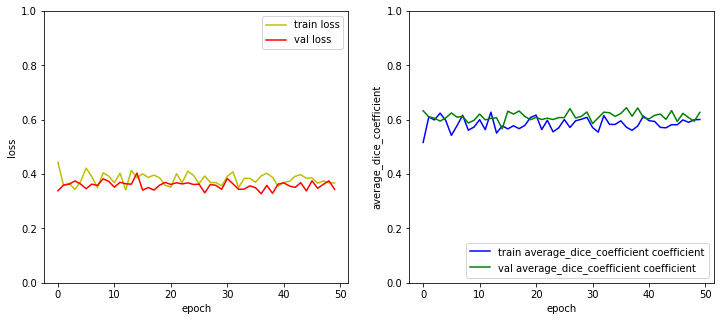

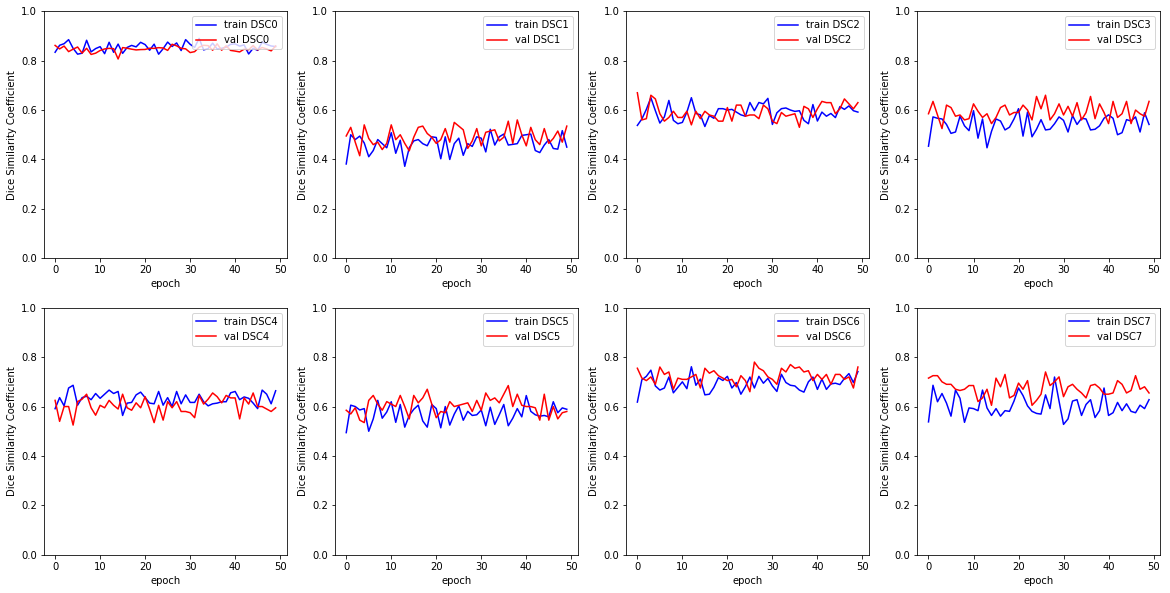

In [38]:
val1_dsc_exp12, val2_dsc_exp12 = model_evaluate('exp910111213141516', 'UNET_3D_COORD', 'average_dice_coefficient', [valid_1, valid_2])

exp_image_1 label:  [0]
exp_image_2 label:  [0]

encoding exp_image_1.shape:  (512, 512, 297, 8)
encoding exp_image_2.shape:  (512, 512, 363, 8)

Valid 1
DSC: 0.9481
label_0: 0.973
label_1: 0.000
label_2: 0.000
label_3: 0.000
label_4: 0.000
label_5: 0.000
label_6: 0.000
label_7: 0.000
Average DSC: 0.000
Valid 2
DSC: 0.8452
label_0: 0.916
label_1: 0.000
label_2: 0.000
label_3: 0.000
label_4: 0.000
label_5: 0.000
label_6: 0.000
label_7: 0.000
Average DSC: 0.000


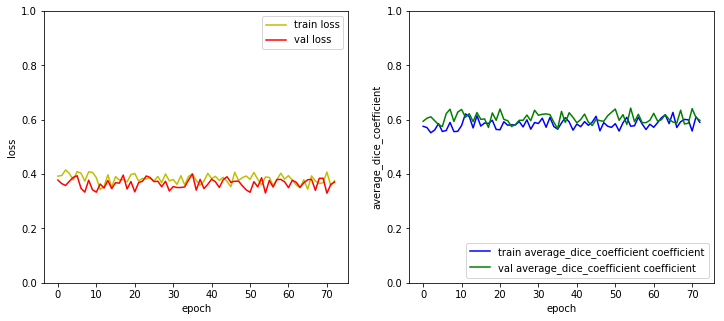

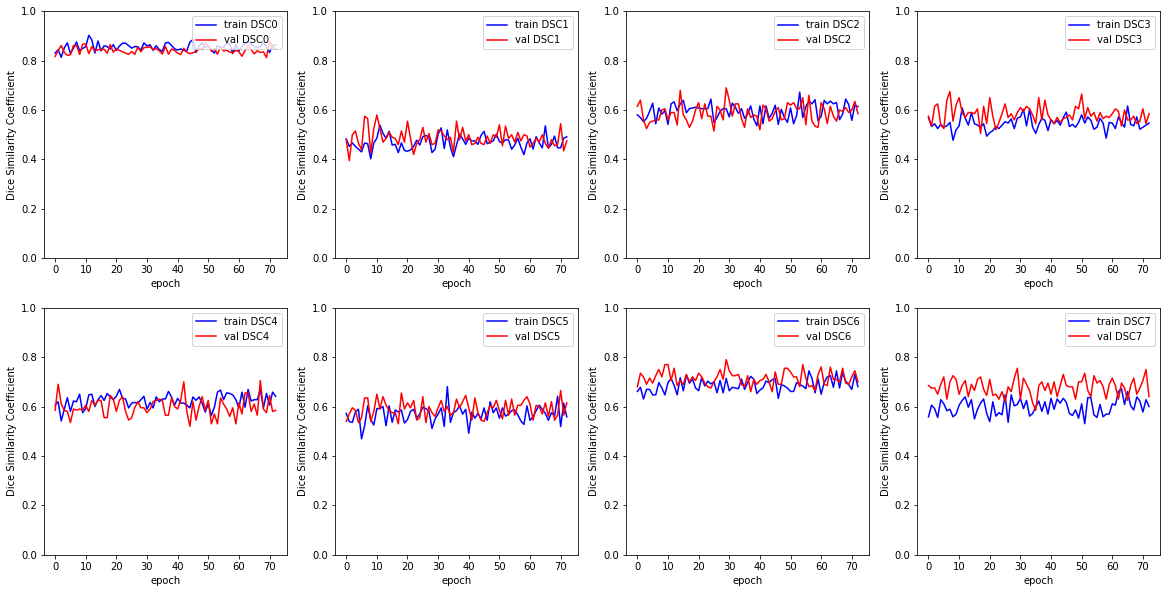

In [40]:
val1_dsc_exp13, val2_dsc_exp13 = model_evaluate('exp910111213141516', 'UNET_3D_COORD_INPUT', 'average_dice_coefficient', [valid_1, valid_2])

exp_image_1 label:  [  0 420]
exp_image_2 label:  [  0 420]

encoding exp_image_1.shape:  (512, 512, 297, 8)
encoding exp_image_2.shape:  (512, 512, 363, 8)

Valid 1
DSC: 0.9481
label_0: 0.973
label_1: 0.000
label_2: 0.000
label_3: 0.000
label_4: 0.000
label_5: 0.000
label_6: 0.000
label_7: 0.000
Average DSC: 0.000
Valid 2
DSC: 0.8452
label_0: 0.916
label_1: 0.000
label_2: 0.000
label_3: 0.000
label_4: 0.000
label_5: 0.000
label_6: 0.000
label_7: 0.000
Average DSC: 0.000


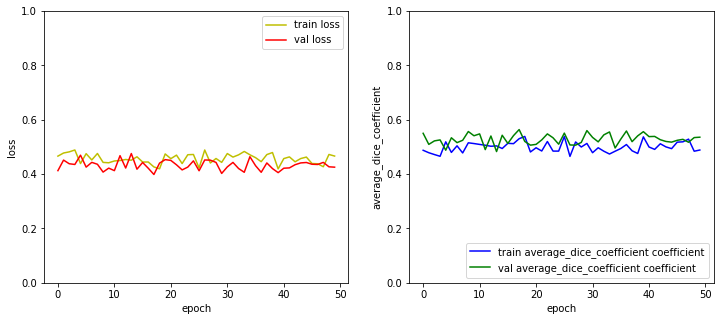

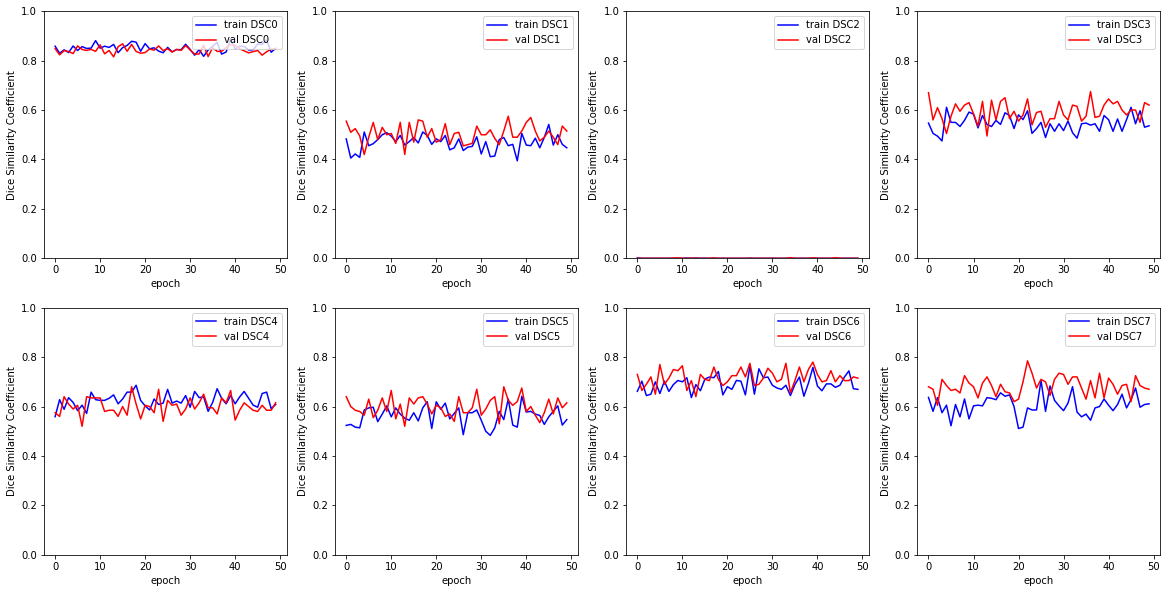

In [41]:
val1_dsc_exp14, val2_dsc_exp14 = model_evaluate('exp910111213141516', 'UNET_3D_COORD_BOTH', 'average_dice_coefficient', [valid_1, valid_2])

exp_image_1 label:  [0]
exp_image_2 label:  [0]

encoding exp_image_1.shape:  (512, 512, 297, 8)
encoding exp_image_2.shape:  (512, 512, 363, 8)

Valid 1
DSC: 0.9481
label_0: 0.973
label_1: 0.000
label_2: 0.000
label_3: 0.000
label_4: 0.000
label_5: 0.000
label_6: 0.000
label_7: 0.000
Average DSC: 0.000
Valid 2
DSC: 0.8452
label_0: 0.916
label_1: 0.000
label_2: 0.000
label_3: 0.000
label_4: 0.000
label_5: 0.000
label_6: 0.000
label_7: 0.000
Average DSC: 0.000


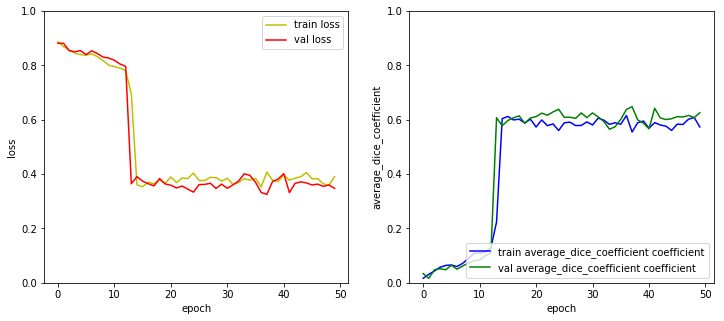

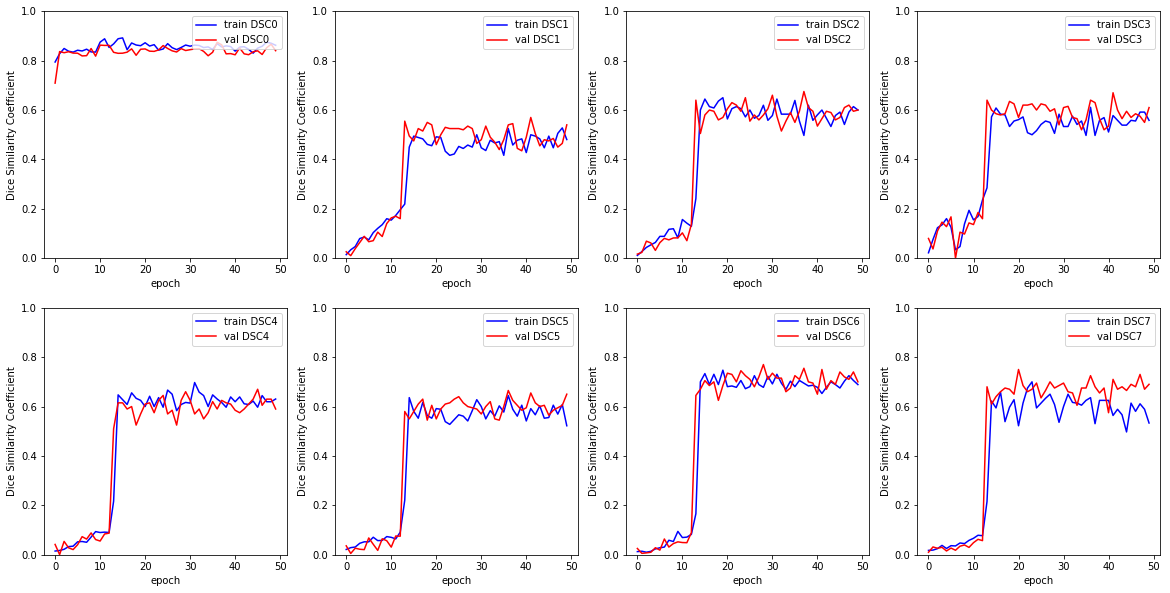

In [42]:
val1_dsc_exp15, val2_dsc_exp15 = model_evaluate('exp910111213141516', 'UNET_3D_N', 'average_dice_coefficient', [valid_1, valid_2])

exp_image_1 label:  [0]
exp_image_2 label:  [0]

encoding exp_image_1.shape:  (512, 512, 297, 8)
encoding exp_image_2.shape:  (512, 512, 363, 8)

Valid 1
DSC: 0.9481
label_0: 0.973
label_1: 0.000
label_2: 0.000
label_3: 0.000
label_4: 0.000
label_5: 0.000
label_6: 0.000
label_7: 0.000
Average DSC: 0.000
Valid 2
DSC: 0.8452
label_0: 0.916
label_1: 0.000
label_2: 0.000
label_3: 0.000
label_4: 0.000
label_5: 0.000
label_6: 0.000
label_7: 0.000
Average DSC: 0.000


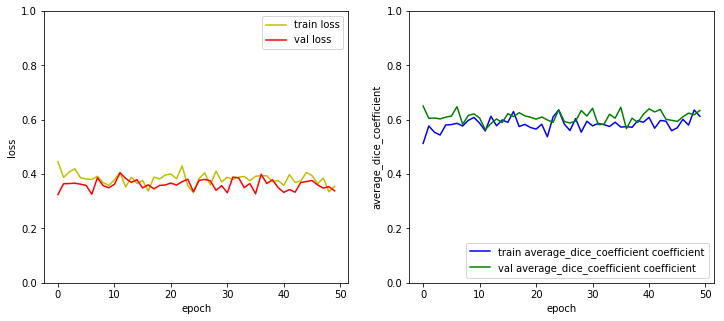

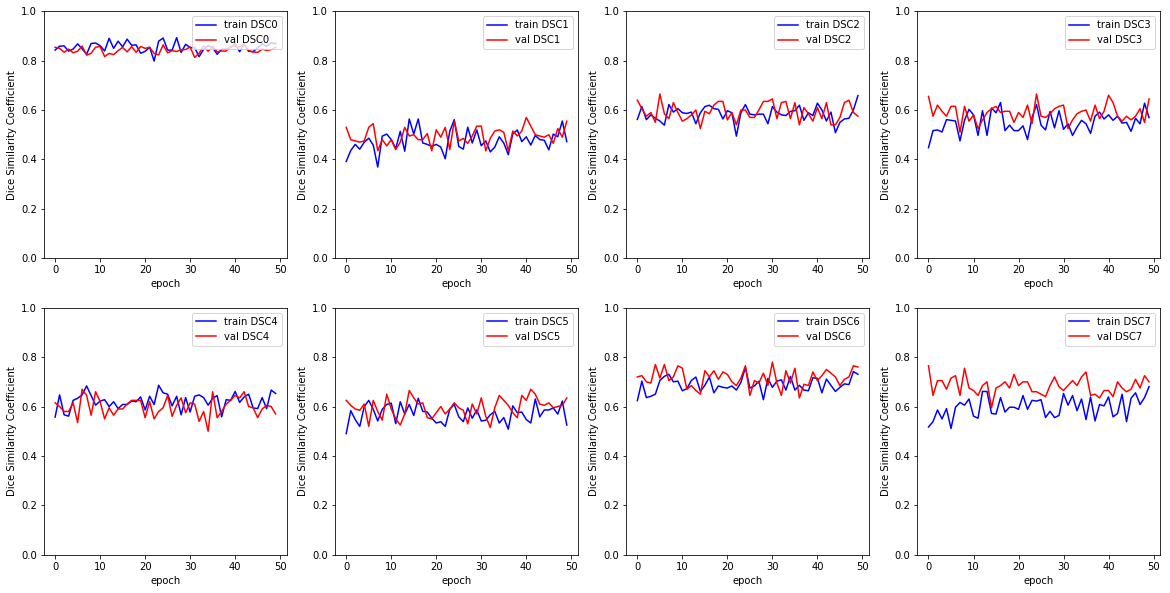

In [43]:
val1_dsc_exp16, val2_dsc_exp16 = model_evaluate('exp910111213141516', 'UNET_3D_COORD_N', 'average_dice_coefficient', [valid_1, valid_2])

In [44]:
val1_dsc_exp17, val2_dsc_exp17 = model_evaluate('exp910111213141516', 'UNET_3D_COORD_INPUT_N', 'average_dice_coefficient', [valid_1, valid_2])

FileNotFoundError: No such file or no access: '../exp910111213141516/predict_image/UNET_3D_COORD_INPUT_N/UNET_3D_COORD_INPUT_N_0.nii'